In [1]:
#For Kaggle
#date=''

#For WL data
source='WL'
date='20241118'

saveImage=False

print('done')

done


In [2]:
import sys
import os
from importlib import reload
fpath = os.path.join('..//scripts')
sys.path.append(fpath)

import warnings
warnings.filterwarnings('ignore')

#loading internal scripts
import frauddetection as fd
import sourcedata as sd
import dataimport as di
import result as resultMd
reload(fd)
reload(sd)
reload(di)
reload(resultMd)

print('done')

done


In [3]:
import pandas as pd

dfTrx = pd.read_csv('../data/cleaned/'+source+'export'+date+'.csv')
dfTrx.head(5)

,db_uuid,trx_date_time,term_mcc,term_country,mcd_fraud_score,vaa_score,trx_cnp,card_pan_id,Class,ecom,...,clusterCardHolder_cluster3,clusterCardHolder_cluster4,clusterMerchant_M0,clusterMerchant_M1,clusterMerchant_M2,clusterMerchant_M3,clusterMerchant_UNKNOWN,trx_amount_log10,previous_trx,distancePrevTrx
0,31BD8D38A53C11EFABA49D2778D26ADA,2024-11-18 00:29:22,5499,NLD,214.000000,26.258093,1,450280D96024C965163D7F15687156B138E1BDCB6DC512...,0,1,...,0,0,1,0,0,0,0,1.690107,0,1.1
1,A3E698CEA53B11EFABA49D2778D26ADA,2024-11-18 00:27:12,5499,NLD,225.222235,32.000000,1,68B7CAD29BF263AD2CE80B155DD3D3EE783884F72F7070...,0,1,...,0,0,1,0,0,0,0,1.799272,0,1.1
2,C5D7AAE6A53A11EFAAA0DF784AB5695E,2024-11-18 00:20:15,7011,BEL,152.000000,26.258093,0,02587C2F031D3D22C997A9A4E6CB78D6A87A2C73E61131...,0,1,...,0,0,0,0,0,1,0,1.374015,0,1.0
3,9C87AE3EA53F11EFABA49D2778D26ADA,2024-11-18 00:53:48,5542,BEL,225.222235,26.258093,1,CD32793A75DE03806C854CB3B6C2DF5BB2809C2DA66BA9...,0,1,...,0,1,0,0,0,1,0,1.205204,0,1.0
4,9C87B0B4A53F11EFABA49D2778D26ADA,2024-11-18 00:53:48,5542,BEL,225.222235,26.258093,1,CD32793A75DE03806C854CB3B6C2DF5BB2809C2DA66BA9...,0,1,...,0,1,0,0,0,1,0,1.205204,0,1.1


In [4]:
from sklearn.model_selection import train_test_split

predictors = fd.getPredictors(dfTrx)
TEST_SIZE = 0.20 # test size using_train_test_split
RANDOM_STATE = 0
x_train0, x_test, y_train0, y_test = train_test_split(dfTrx[predictors], dfTrx['Class'], test_size = TEST_SIZE, 
                                                        stratify= dfTrx['Class'],
                                                        random_state = RANDOM_STATE)

#scaler=StandardScaler()
#x_train= scaler.fit_transform(x_train0)
#x_test= scaler.transform(x_test)
x_train= x_train0.copy()
x_test = x_test.copy()

In [5]:
%%script false
# found rate =1/120

from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

train_f1s=[]
test_f1s =[]
range= []

#rates =[0.99,0.9,0.5,0.25,0.2, 0.1,0.05, 0.01,0.0075, 0.005, 0.0025]
#rates = np.arange(5,401,5)
#rates = np.arange(5,401,50) --> 100
#rates = np.arange(40,201,20) --> 120
rates = np.arange(60,161,10)  #--> 120
for rate in rates:
    print("",rate,1/rate)
    undersample = RandomUnderSampler(sampling_strategy=1/rate,random_state=42)
    x_train, y_train = undersample.fit_resample(x_train0, y_train0)

    print(x_train.shape)
    #print(y_train.value_counts())
    
    modelClf = GradientBoostingClassifier(random_state=42)
    parameters={'learning_rate': 0.01, 'n_estimators':110, 'max_depth':8}
    modelClf.set_params(**parameters)

    modelClf.fit(x_train, y_train)
    predsTrain = modelClf.predict(x_train)
    predsTest = modelClf.predict(x_test)

    train_f1=fd.calculate_scores(y_train, predsTrain,'f1')
    print("f1 train {:.4f}".format(train_f1))
    test_f1=fd.calculate_scores(y_test, predsTest,'f1')
    print("f1 test  {:.4f}".format(test_f1))
    
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
    range.append(rate)
    print('-----------------------')

fd.plt_train_test(range, train_f1s, "train", test_f1s," test")

Couldn't find program: 'false'


(120274, 31)
test-set confusion matrix:
 [[119279      1]
 [   728    266]]
accuracy score: 0.9939
balanced accuracy score: 0.6338
recall score: 0.2676
precision score: 0.9963
f1 score: 0.4219
mcc score: 0.5148
roc auc score: 0.6338
test-set confusion matrix:
 [[211614    108]
 [   201     47]]
accuracy score: 0.9985
balanced accuracy score: 0.5945
recall score: 0.1895
precision score: 0.3032
f1 score: 0.2333
mcc score: 0.2390
roc auc score: 0.5945


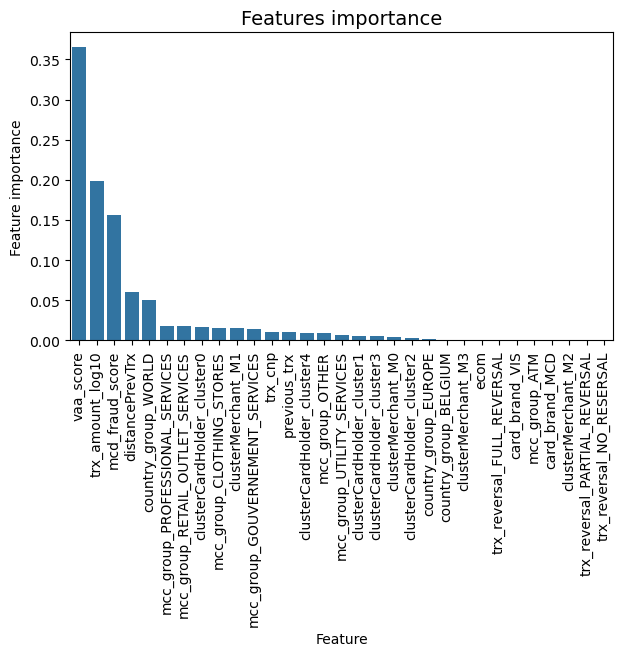

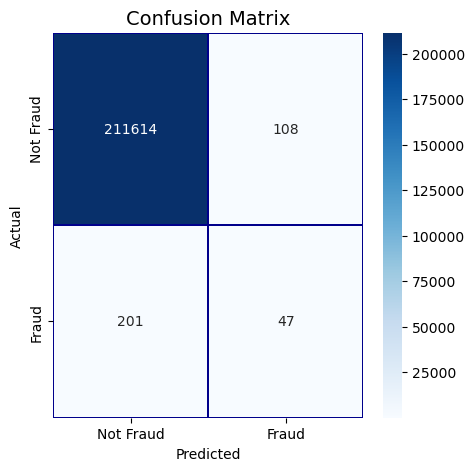

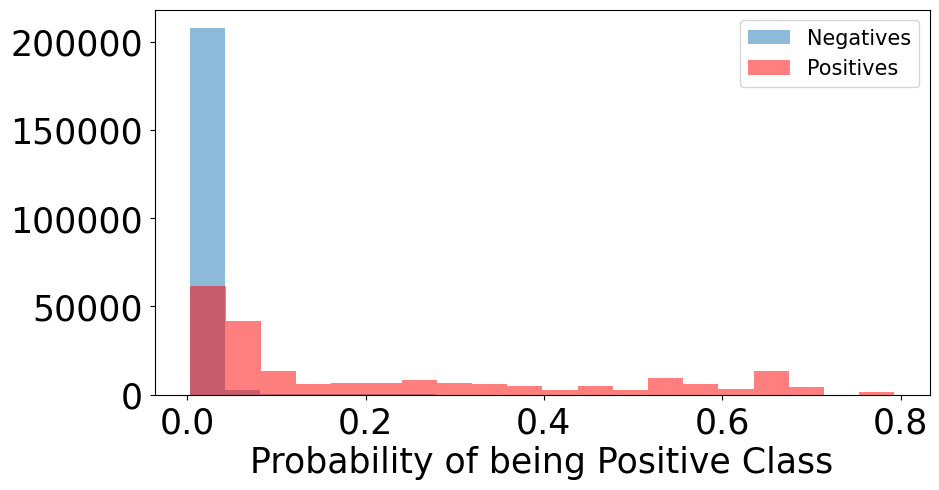

In [6]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier


undersample = RandomUnderSampler(sampling_strategy=1/120,random_state=42)
x_train, y_train = undersample.fit_resample(x_train0, y_train0)
print(x_train.shape)  

    
modelClf = GradientBoostingClassifier(random_state=42)
parameters={'learning_rate': 0.01, 'n_estimators':110, 'max_depth':8}
modelClf.set_params(**parameters)
modelClf.fit(x_train, y_train)

predsTrain = modelClf.predict(x_train)
predsTest = modelClf.predict(x_test)

fd.print_scores(y_train, predsTrain,'f1', False)
fd.print_scores(y_test, predsTest,'f1')
fd.show_importance(modelClf, predictors)
fd.show_confusion_matrix(y_test, predsTest)
fd.show_prediction_graph(modelClf, x_test,y_test)

--- threshold -- 0.025
test-set confusion matrix:
 [[205611   6111]
 [    57    191]]
accuracy score: 0.9709
balanced accuracy score: 0.8706
recall score: 0.7702
precision score: 0.0303
f1 score: 0.0583
mcc score: 0.1492
roc auc score: 0.8706
--- threshold -- 0.05
test-set confusion matrix:
 [[208261   3461]
 [    75    173]]
accuracy score: 0.9833
balanced accuracy score: 0.8406
recall score: 0.6976
precision score: 0.0476
f1 score: 0.0891
mcc score: 0.1794
roc auc score: 0.8406
--- threshold -- 0.1
test-set confusion matrix:
 [[210725    997]
 [   132    116]]
accuracy score: 0.9947
balanced accuracy score: 0.7315
recall score: 0.4677
precision score: 0.1042
f1 score: 0.1705
mcc score: 0.2190
roc auc score: 0.7315
--- threshold -- 0.15
test-set confusion matrix:
 [[210972    750]
 [   141    107]]
accuracy score: 0.9958
balanced accuracy score: 0.7140
recall score: 0.4315
precision score: 0.1249
f1 score: 0.1937
mcc score: 0.2305
roc auc score: 0.7140
--- threshold -- 0.2
test-set co

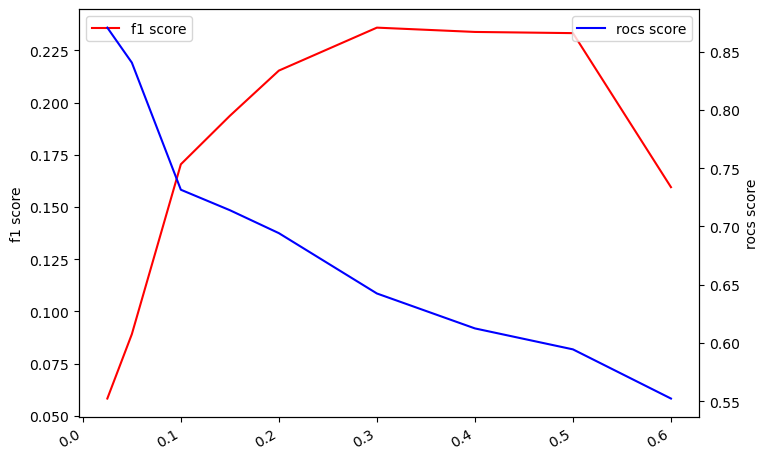

In [7]:
y_pred_prob = modelClf.predict_proba(x_test)[:,1]

range = []
f1s = []
rocs = []
for threshold  in [0.025,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6]:
    print("--- threshold --", threshold)
    y_pred_adjusted = (y_pred_prob>threshold).astype(int)
    f1,mcc,roc=fd.print_scores(y_test, y_pred_adjusted,'all')
    range.append(threshold)
    f1s.append(f1)
    rocs.append(roc)

fd.plt_train_test(range, f1s,"f1 score",rocs,"rocs score")

export20241118.csv
test-set confusion matrix:
 [[1057264    1343]
 [    768     474]]
accuracy score: 0.9980
balanced accuracy score: 0.6902
recall score: 0.3816
precision score: 0.2609
f1 score: 0.3099
mcc score: 0.3146
roc auc score: 0.6902


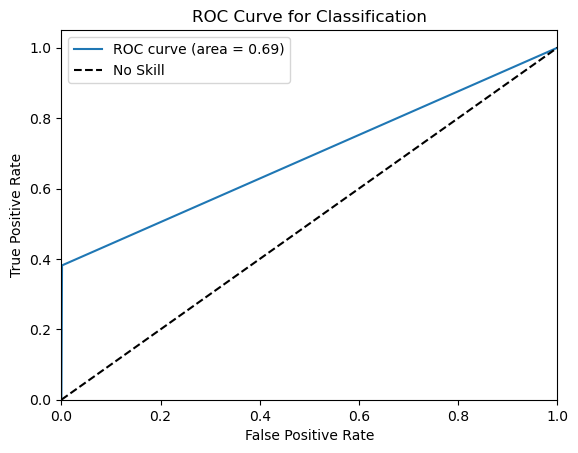

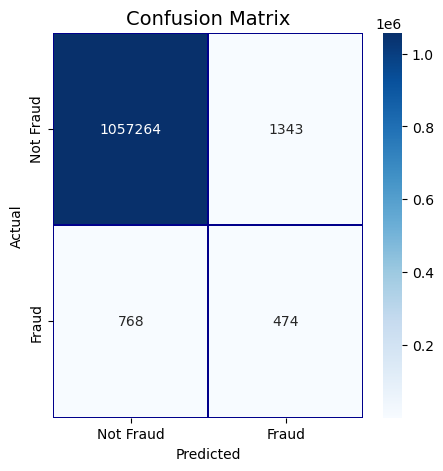

export20241119.csv
test-set confusion matrix:
 [[987336   1575]
 [   841    306]]
accuracy score: 0.9976
balanced accuracy score: 0.6326
recall score: 0.2668
precision score: 0.1627
f1 score: 0.2021
mcc score: 0.2072
roc auc score: 0.6326


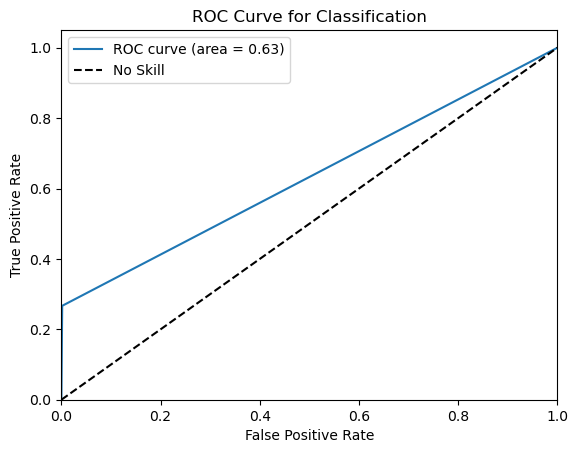

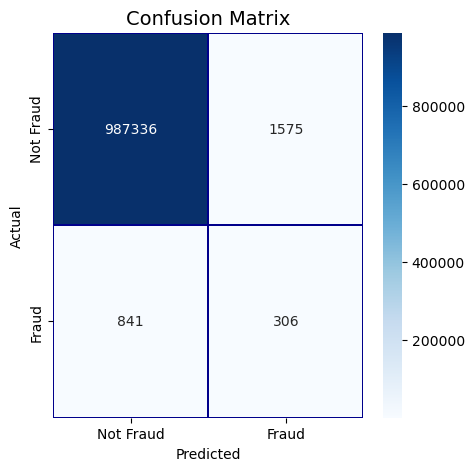

export20241120.csv
test-set confusion matrix:
 [[1065663    1461]
 [   1090     228]]
accuracy score: 0.9976
balanced accuracy score: 0.5858
recall score: 0.1730
precision score: 0.1350
f1 score: 0.1516
mcc score: 0.1516
roc auc score: 0.5858


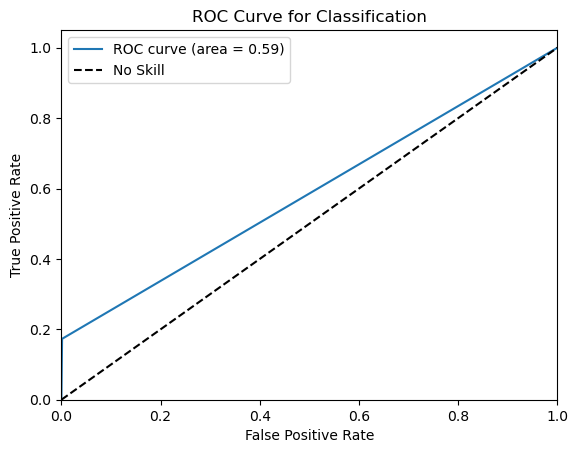

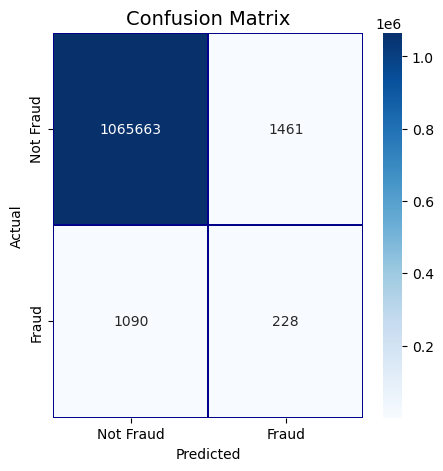

export20241121.csv
test-set confusion matrix:
 [[1073853    1431]
 [   1055     159]]
accuracy score: 0.9977
balanced accuracy score: 0.5648
recall score: 0.1310
precision score: 0.1000
f1 score: 0.1134
mcc score: 0.1133
roc auc score: 0.5648


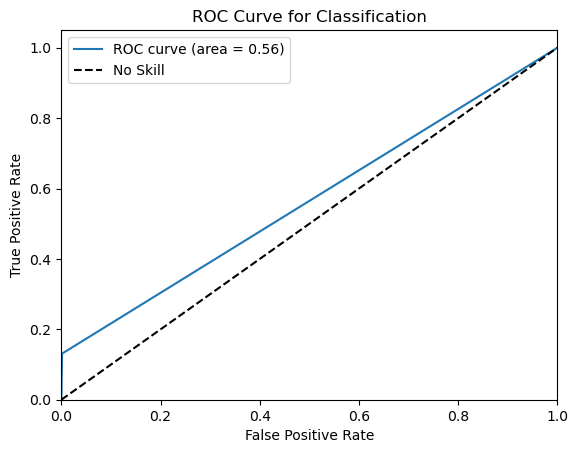

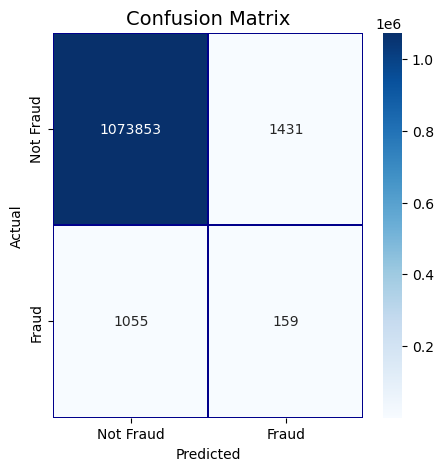

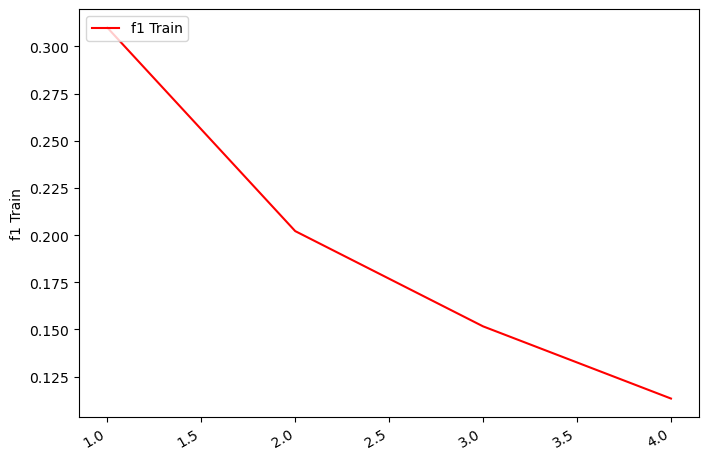

In [18]:
files = fd.getAllFiles()

range = []
f1s = []
rocs = []
loop =0
threshold=0.3

for file in files:
    loop=loop+1
    range.append(loop)
    print(file)
  
    dfTrx = pd.read_csv('../data/cleaned/'+source+file)
    predictors = fd.getPredictors(dfTrx)

    y_pred_prob = modelClf.predict_proba(dfTrx[predictors])[:,1]
    y_pred_adjusted = (y_pred_prob>threshold).astype(int)

    f1,mcc,roc= fd.print_scores(dfTrx['Class'], y_pred_adjusted,'All', True)
    
    #fd.show_importance(modelClf,predictors)
    fd.show_confusion_matrix(dfTrx['Class'], y_pred_adjusted)

    f1s.append(f1)
    rocs.append(roc)

fd.plt_train_test(range, f1s)



resultMd.update_performance_nextdays_result('07-sklearn.ensemble.b-boosting','GradientBoostingClassifier','4-After undersampling', f1s[0],f1s[1],f1s[2],f1s[3],rocs[0],rocs[1],rocs[2],rocs[3])

